In [1]:
# %matplotlib qt
from f3ast import *

import matplotlib.pyplot as plt

### Export calibration stream

In [2]:
calib_strm_savepath = 'calibstrm'

# create safe filename to prevent overwriting
calib_strm_savepath = create_safe_savename(calib_strm_savepath)
export_spot_calibration(calib_strm_savepath, start_time=1, end_time=15, grid=[5, 3])

Total time:  0:02:00


### Get the image and the data

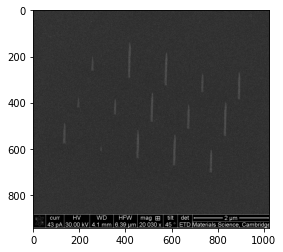

In [3]:
img_path = 'calib1_001.tif'
data_path = 'calib25-11-19_data.txt'
observing_angle = 45

data = np.loadtxt(data_path, delimiter='\t', skiprows=1)
dwell_times = data[:, 0]

img = read_image(img_path)
plt.imshow(img)

### Set the scale

In [4]:
# need to use qt backend for this
%matplotlib qt
tracker = select_scale(img)

83, 21
403, 24


In [5]:
scale_bar_size = 2 # in um

scale_bar_px = np.abs(tracker.scale_markers[1] - tracker.scale_markers[0])
ppn = scale_bar_px / scale_bar_size
print('Pixels per nanometer: ', ppn)

Pixels per nanometer:  159.89609023050875


### Process calibration image

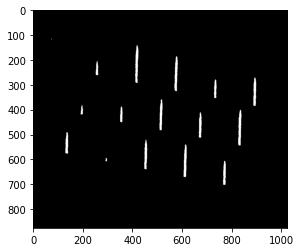

In [6]:
%matplotlib inline
# remove the bar and threshold the image
img_nobar = remove_bottom_bar(img)
img_thresh = threshold_image(img_nobar, thresh=None)
# try_all_threshold(img_smooth)
plt.imshow(img_thresh)

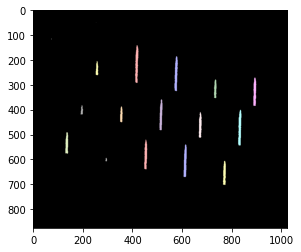

In [7]:
# label image regions
label_image, image_label_overlay = get_labelled_image(img_thresh)
labels = filter_small_labels(label_image)
image_label_overlay = label2rgb(label_image, image=img_thresh, bg_label=0)
plt.imshow(image_label_overlay)

In [8]:
# get lengths of the structures
lengths_px = get_lengths_px(label_image)
lengths_perspective = np.sort(lengths_px) / ppn
lengths_true = lengths_perspective / np.sin(np.deg2rad(observing_angle))
dwell_times = dwell_times[-lengths_true.size:]

### Fit the model

GR:  0.20024693911162778
k:  1.1258281441350222


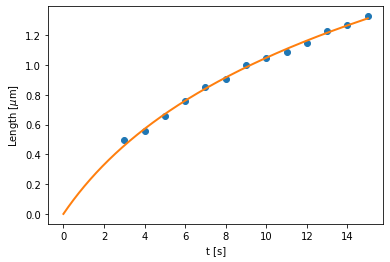

In [9]:
# fit the deposit model and get the parameters
deposit_model, popt, _ = DDModel.fit_calibration(dwell_times, lengths_true)

t = np.linspace(0, np.max(dwell_times), 1000)
plt.figure()
plt.plot(t, deposit_model(t, *popt), color='tab:orange', linewidth=2)
plt.scatter(dwell_times, lengths_true)
plt.xlabel('t [s]')
plt.ylabel(r'Length [$\mu$m]');

### Get the sigma calibration structures if necessary

In [10]:
# model = DDModel(gr=popt[0], k=popt[1], sigma=None)
model = RRLModel(None, gr=popt[0], sigma=None)
sigma_list = [3, 4, 5, 6]
file_path = "sigma_calib"

sigma_strm = get_sigma_structures(model, sigma_list)
sigma_strm.print_time()

sigma_strm.write(create_safe_savename(file_path))

Solving for dwells...
Slicing...
Sliced
Solved
Solving for dwells...
Solved
Solving for dwells...
Solved
Solving for dwells...
Solved
Solving for dwells...
Slicing...
Sliced
Solved
Total time:  0:01:33.572785


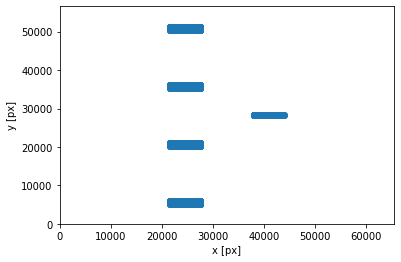

In [11]:
sigma_strm.show_on_screen()